# Determining the age of buyers

The chain supermarket "Bread-Salt" introduces a computer vision system for processing customer photos. 

Photo fixation in the checkout area will help determine the age of customers in order to:
* Analyze purchases and offer products that may be of interest to buyers of this age group;
* Monitor the integrity of cashiers when selling alcohol.

Build a model that can determine the approximate age of a person from a photo. At щгк disposal is a set of photos of people with age indication.

## Research data analysis

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255.)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

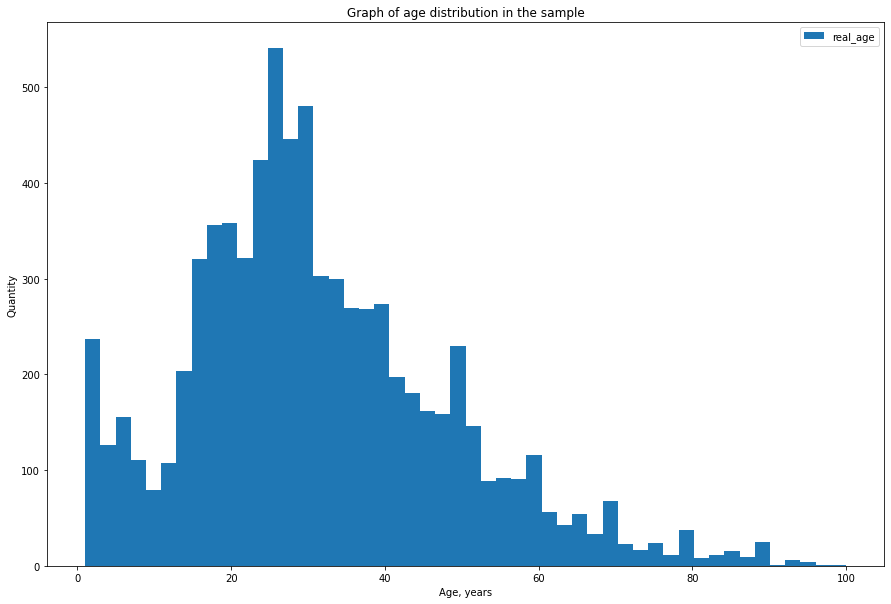

In [7]:
labels.plot(kind='hist',figsize=(15,10),bins=50)
plt.title('Graph of age distribution in the sample')
plt.xlabel('Age, years')
plt.ylabel('Quantity')
plt.show()

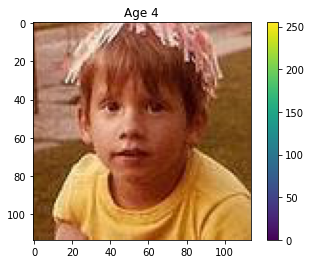

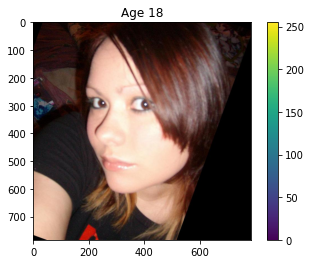

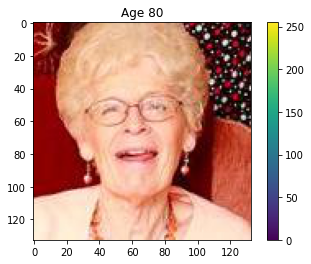

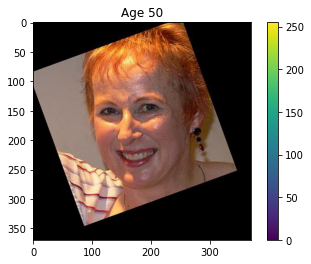

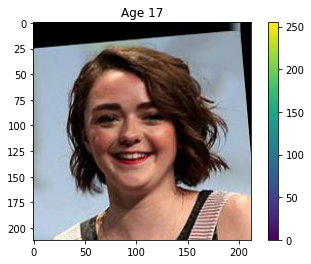

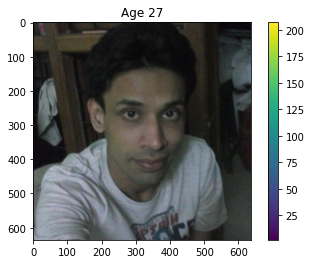

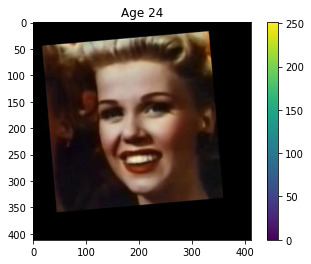

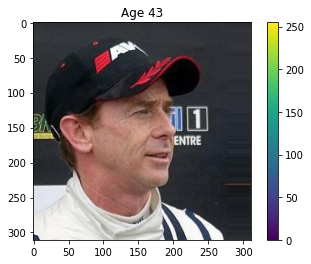

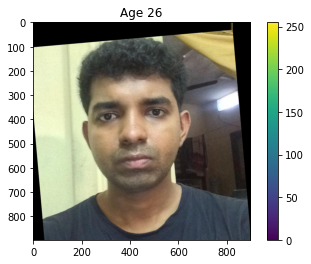

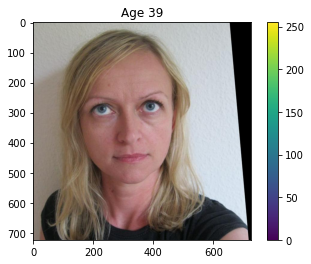

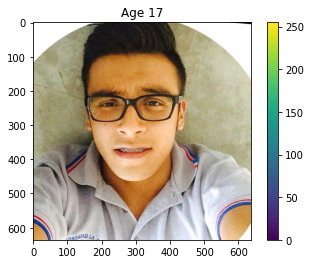

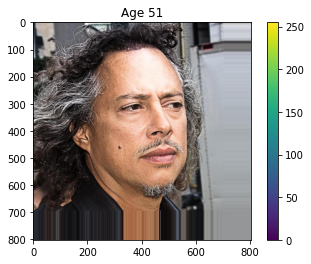

In [8]:
for i,k in zip(labels.file_name[:12],labels.real_age[:12]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

### Conclusion

Judging by the distribution, this sample contains quite a lot of photos of people aged about 25 years

Many photos have an offset, which can be taken into account when building and training the model

It is also worth noting that there are photos with some blurring and defects, which in turn can have an impact on the training of the model

## Model Training

(The code in this section runs in a separate GPU simulator, so it is designed not as a cell with a code, but as a code in a text cell)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd



def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Epoch 2/10
178/178 - 49s - loss: 93.9800 - mae: 7.2959 - val_loss: 325.9918 - val_mae: 13.3463
Epoch 3/10
178/178 - 49s - loss: 72.5821 - mae: 6.4868 - val_loss: 307.5567 - val_mae: 13.0776
Epoch 4/10
178/178 - 49s - loss: 52.8272 - mae: 5.5437 - val_loss: 156.3203 - val_mae: 9.2769
Epoch 5/10
178/178 - 51s - loss: 40.4588 - mae: 4.8925 - val_loss: 101.1309 - val_mae: 7.4912
Epoch 6/10
178/178 - 51s - loss: 32.4918 - mae: 4.3454 - val_loss: 145.1432 - val_mae: 9.4843
Epoch 7/10
178/178 - 51s - loss: 25.4774 - mae: 3.8571 - val_loss: 70.6875 - val_mae: 6.2292
Epoch 8/10
178/178 - 50s - loss: 20.9523 - mae: 3.5319 - val_loss: 71.6292 - val_mae: 6.3329
Epoch 9/10
178/178 - 48s - loss: 20.7560 - mae: 3.4553 - val_loss: 79.6420 - val_mae: 6.9604
Epoch 10/10
178/178 - 49s - loss: 16.4964 - mae: 3.0844 - val_loss: 69.6689 - val_mae: 6.2520
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 69.6689 - mae: 6.2520
Test MAE: 6.2520

```

## Analysis of the trained model

As initial data for determining the age of people from photographs, we used a dataset with posted data of about 7.5 thousand photos (judging by the distribution, a significant part are people aged about 25 years).

The ResNet50 model was trained on 75% of the data from the entire dataset and 10 epochs were carried out

Based on the results of training and testing of the model, the value of MAE < 8 was achieved, which was required

We can conclude about the effectiveness of this neural network

It is also worth noting that this trained neural network performs the tasks set earlier, and can also be useful in businesses from other areas.